# SModelS – a tool for interpreting simplified-model results from the LHC

 <img src=https://smodels.github.io/images/banner720.png />

Wolfgang Waltenberger (ÖAW and Uni Vienna), for the SModelS collaboration.

PyHEP 2020 virtual conference, July 2020.

<img src=https://smodels.github.io/walten/scheme1.png width=480>

## Preparatory step -- installation:

In [1]:
# smodels is registered at the python packaging index
!pip install smodels

To run this exercise, we need a theory, given as an slha file. We prepared "pyhep2020.slha" for you, 
but feel free to upload and run your own favorite model.
The "slha-plot" of pyhep202.slha looks like this:

<img src=https://smodels.github.io/walten/slhaplot.png width=480>

## Part 1: Problem statement

Q: What problem does SModelS try to address?

A: SModelS is a tool for BSM (Beyond the Standard Model) physics. The problem with BSM physics is that **we are confronted with an entire landscape of promising models**:

<img width=400px src=https://smodels.github.io/walten/hitoshi.png?3 />

The above picture shows Hitoshi Murayamas' impression of the theory landscape. 
Many theories are shown. Most of them come with many free parameters.

These theories want to be **confronted with a large number of experimental results**:

<img width=350px src="https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PUBNOTES/ATL-PHYS-PUB-2020-013/fig_23.png" />
<img width=350px src="https://twiki.cern.ch/twiki/pub/CMSPublic/SUSYSummary2017/Moriond2017_BarPlot.png" />

SModelS is a tool that aims at confronting BSM theories with the slew of searches for new physics. We do not address
measurements (which may also constrain BSM physics). How we do this? SModelS has two main components: **a database of experimental results, and a "theory decomposer"**. Let's start with the database:

## Part 2: Simplified Models (recap)

To recap: a simplified model is an "unphysical" theoretical model with only a minimum BSM particle content,
fixed production modes, fixed branching ratios, and with the signal strength being a free parameter of the model.

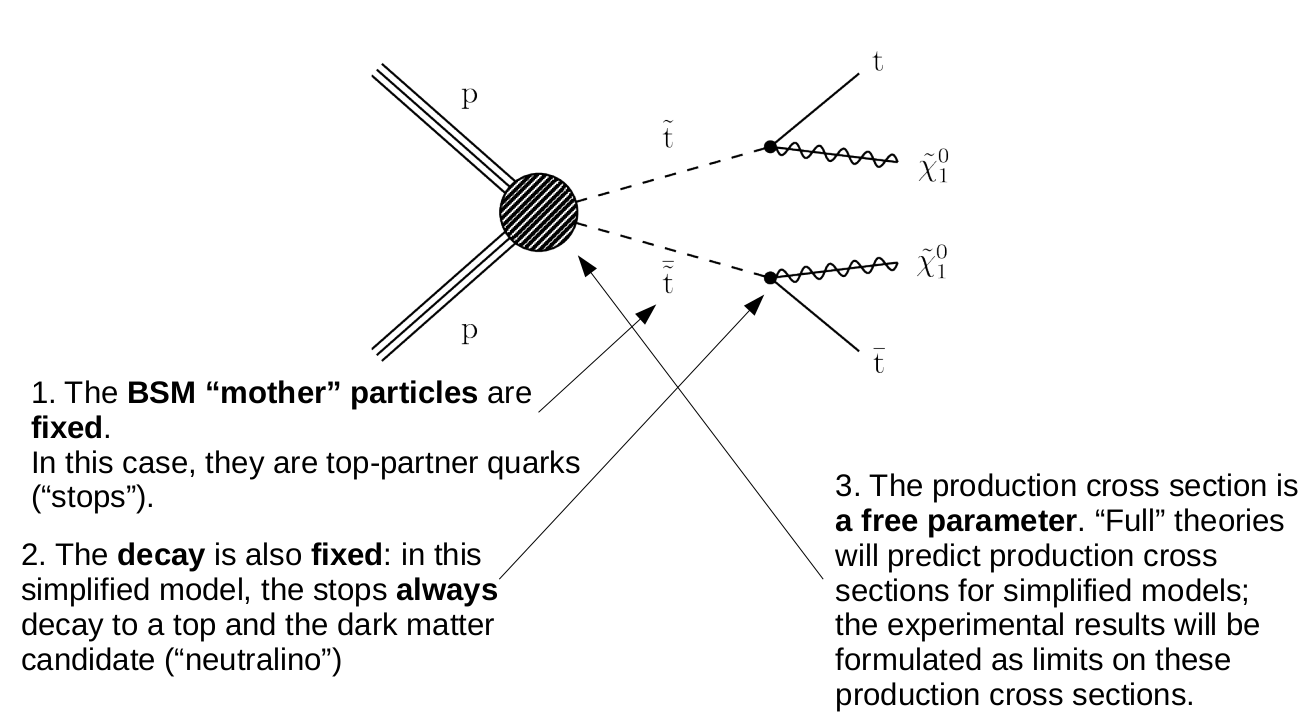

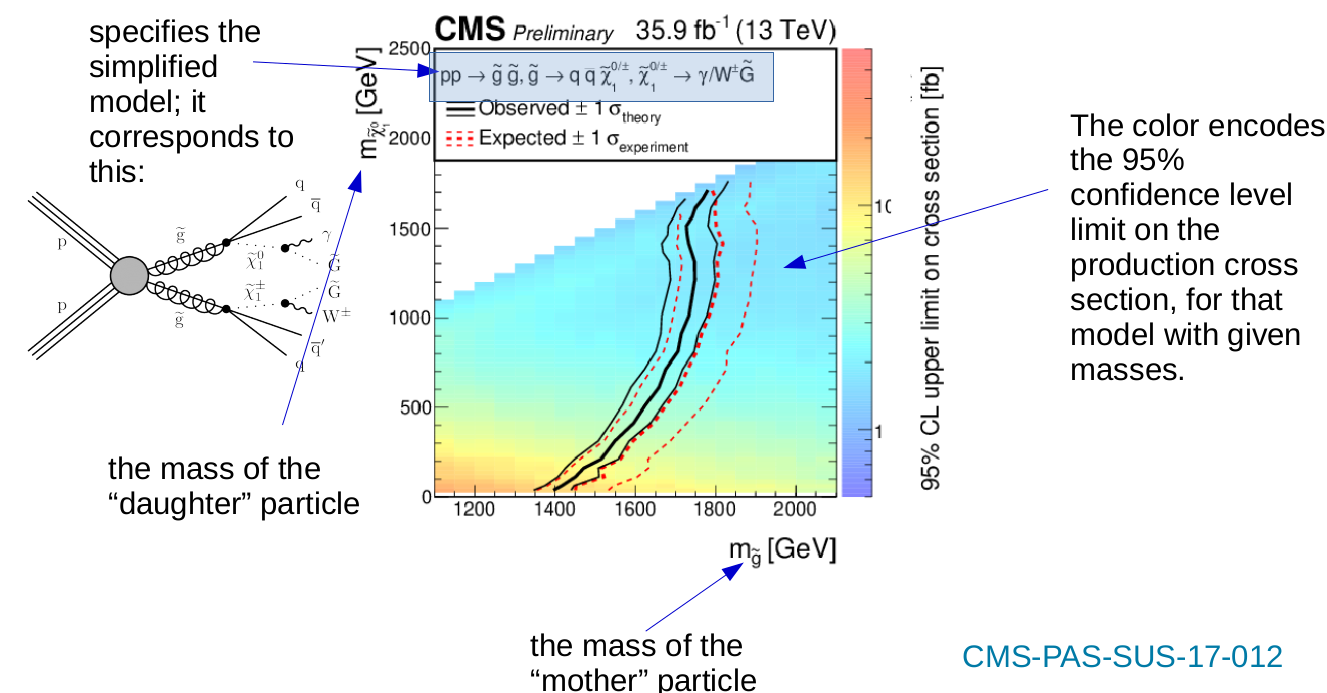

## Part 3: The Database

<img src=https://smodels.github.io/walten/scheme2.svg?5 width=480>

In [2]:
from smodels.experiment.databaseObj import Database

In [3]:
# instantiate a database. triggers a download from a CERN server.
# in this tutorial, you are free to use either our "unittest" database, 
# or the "official" v1.2.3 database. "official" is about 1 GB large,
# so if things are small, then use "unittest"
database = Database ( "unittest" ) ## "official"
print ( database )

Database version: unittest123
------------------------------
11 experimental results: 7 CMS, 4 ATLAS, 7 @ 8 TeV, 4 @ 13 TeV
109 datasets, 536 txnames.



In [4]:
## databases can of course also be constructed or augmented by the user. In its raw form, it consists of many 
## editable text files that get translated into a binary database by the framework. See e.g. here:
## https://smodels.readthedocs.io/en/stable/DatabaseDefinitions.html
## If needed, we can provide the tools that help in creating new entries.

In [5]:
## lets find out how many results we find in the database. Some results are superseded (i.e. an update of the same
## analysis but with more data was published later), we filter them out.

len(database.getExpResults(useNonValidated=False, useSuperseded=False ))

10

In [6]:
## exp results can have multiple signal regions -- we call them datasets. Lets count the number of datasets in the
## database.

In [7]:
sum([ len(x.datasets) for x in database.getExpResults( useSuperseded=False ) ])

108

In [8]:
## finally, per signal region we may have results for several simplified models, lets count the total
## number of efficiency maps

In [9]:
sum([ sum([ len(y.txnameList) for y in x.datasets ]) for x in database.getExpResults( useSuperseded=False ) ])

535

In [10]:
## we have two types of results, upper-limit type (upper limits on production cross sections) and efficiency-map 
## type results. For upper-limit type results we sometimes have expected upper limits in addition to 
## observed upper limits. For such cases, as well as for effiency-map type results, we can contruct likelhoods.

## Let's count the number of "maps" for which we have likelihoods

In [11]:
sum([ sum([ len([z for z in y.txnameList if z.hasLikelihood() ] ) for y in x.datasets ]) for x in database.getExpResults() ])

515

In [12]:
## the last line was difficult to read. let's do this more slowly:

countLikelihoods = 0

for expRes in database.getExpResults():
    for ds in expRes.datasets:
        for txn in ds.txnameList:
            if txn.hasLikelihood():
                countLikelihoods += 1
                
print ( f"I am counting {countLikelihoods} likelihoods.")

I am counting 515 likelihoods.


## Part 4: The Decomposer

<img src=https://smodels.github.io/walten/scheme3.svg width=480>

The decomposer is tasked with decomposing a given theory into its simplified models spectrum, so the individual 
parts can be matched against the database:

In [13]:
# Import those parts of smodels that are needed for this exercise
# (We will assume the input is a SLHA file. For LHE files, use the lheDecomposer instead)
from smodels.theory import slhaDecomposer
from smodels.installation import installDirectory
from smodels.tools.physicsUnits import fb, GeV, TeV

In [14]:
# Define the SLHA file name that contains the model we wish to decompose
filename="pyhep2020.slha"

In [15]:
# Perform the decomposition. "elements" with predicted cross sections smaller than 0.5 fb
# are discarded. We perform "compression", a procedure that is described here:
# https://smodels.readthedocs.io/en/stable/Decomposition.html#compression-of-elements

listOfTopologies = slhaDecomposer.decompose(filename, sigcut = 0.5 * fb, 
                                            doCompress=True, doInvisible=True,minmassgap = 5* GeV)

In [16]:
## mostly for reasons of efficiency, the simplified model "elements" are grouped into 
## simplified model "topologies". A topology just specifies the overall structure of a simplified model 
## (number of decays, number of particles emitted per decays), while an "element" specifies also the 
## final state Standard Model particle

# Print a summary of all the topologies generated, from simplest to most convoluted:
for top in listOfTopologies:
    print (top.describe())


number of vertices: [0, 0], number of vertex particles: [[], []], number of elements: 1
number of vertices: [0, 1], number of vertex particles: [[], [1]], number of elements: 1
number of vertices: [0, 1], number of vertex particles: [[], [2]], number of elements: 2
number of vertices: [1, 1], number of vertex particles: [[1], [1]], number of elements: 8
number of vertices: [1, 1], number of vertex particles: [[1], [2]], number of elements: 10
number of vertices: [1, 1], number of vertex particles: [[2], [2]], number of elements: 3
number of vertices: [0, 2], number of vertex particles: [[], [2, 1]], number of elements: 9
number of vertices: [1, 2], number of vertex particles: [[1], [1, 1]], number of elements: 28
number of vertices: [1, 2], number of vertex particles: [[1], [1, 2]], number of elements: 4
number of vertices: [1, 2], number of vertex particles: [[1], [2, 1]], number of elements: 50
number of vertices: [1, 2], number of vertex particles: [[2], [1, 1]], number of elements:

In [17]:
## Let's have a look at the elements from the fourth topology, i.e. all "elements" with one decay on each of the
## two branches, one SM particle emerging from each decay:

# We can also print information for each element in the topology:
for element in listOfTopologies[3].elementList:
    print ('Element:',element.getParticles())
    print ('masses=',element.getMasses())
    print ('weight=',element.weight,'\n')

Element: [[['W+']], [['W-']]]
masses= [[2.69E+02 [GeV], 1.29E+02 [GeV]], [2.69E+02 [GeV], 1.29E+02 [GeV]]]
weight= ['8.00E+00 [TeV]:5.96E-02 [pb]', '1.30E+01 [TeV]:1.45E-01 [pb]'] 

Element: [[['W+']], [['Z']]]
masses= [[2.69E+02 [GeV], 1.29E+02 [GeV]], [2.69E+02 [GeV], 1.29E+02 [GeV]]]
weight= ['8.00E+00 [TeV]:1.32E-02 [pb]', '1.30E+01 [TeV]:2.62E-02 [pb]'] 

Element: [[['W+']], [['higgs']]]
masses= [[2.69E+02 [GeV], 1.29E+02 [GeV]], [2.69E+02 [GeV], 1.29E+02 [GeV]]]
weight= ['8.00E+00 [TeV]:6.84E-02 [pb]', '1.30E+01 [TeV]:1.36E-01 [pb]'] 

Element: [[['W-']], [['Z']]]
masses= [[2.69E+02 [GeV], 1.29E+02 [GeV]], [2.69E+02 [GeV], 1.29E+02 [GeV]]]
weight= ['8.00E+00 [TeV]:5.29E-03 [pb]', '1.30E+01 [TeV]:1.37E-02 [pb]'] 

Element: [[['W-']], [['higgs']]]
masses= [[2.69E+02 [GeV], 1.29E+02 [GeV]], [2.69E+02 [GeV], 1.29E+02 [GeV]]]
weight= ['8.00E+00 [TeV]:2.74E-02 [pb]', '1.30E+01 [TeV]:7.11E-02 [pb]'] 

Element: [[['higgs']], [['higgs']]]
masses= [[2.69E+02 [GeV], 1.29E+02 [GeV]], [2.69E+

## Part 5: Putting things together

<img src=https://smodels.github.io/walten/scheme4.svg width=480>

SModelS is a **python library**. However, SModelS also has **a few applications**, executables, 
that should cover many typical use cases:

In [18]:
!runSModelS.py -h

usage: runSModelS.py [-h] -f FILENAME [-p PARAMETERFILE] [-o OUTPUTDIR] [-d]
                     [-t] [-C] [-V] [-c] [-v VERBOSE] [-T TIMEOUT]

Run SModelS over SLHA/LHE input files.

optional arguments:
  -h, --help            show this help message and exit
  -f FILENAME, --filename FILENAME
                        name of SLHA or LHE input file or a directory path
                        (required argument). If a directory is given, loop
                        over all files in the directory
  -p PARAMETERFILE, --parameterFile PARAMETERFILE
                        name of parameter file, where most options are defined
                        (optional argument). If not set, use all parameters
                        from smodels/etc/parameters_default.ini
  -o OUTPUTDIR, --outputDir OUTPUTDIR
                        name of output directory (optional argument). The
                        default folder is: ./results/
  -d, --development     if set, SModelS will run in development

However, since this is a python conference, we focus on SModelS as a library, a module.

In [1]:
## Remember, we had a list of the decomposed elements of the 
## model stored in "listOfTopologies". Now lets match them!

from smodels.theory.theoryPrediction import theoryPredictionsFor

In [20]:
# Compute the theory predictions for each experimental result and print them:
print("\n Theory Predictions and Constraints:")
rmax = 0.
bestResult = None
## use only the first ten results, so we dont get lost
for expResult in database.getExpResults()[:10]:
    predictions = theoryPredictionsFor(expResult, listOfTopologies )
    if not predictions: continue # Skip if there are no constraints from this result
    print('\n %s (%i TeV)' %(expResult.globalInfo.id,expResult.globalInfo.sqrts.asNumber(TeV)))
    for theoryPrediction in predictions:
        dataset = theoryPrediction.dataset
        datasetID = dataset.dataInfo.dataId            
        mass = theoryPrediction.mass
        txnames = [str(txname) for txname in theoryPrediction.txnames]
        PIDs =  theoryPrediction.PIDs         
        print( "------------------------" )
        print( "TxNames = ",txnames )  
        print( "Theory Prediction = ",theoryPrediction.xsection.value )  #Signal cross section
        # Get the corresponding upper limit:
        print( "UL for theory prediction = ",theoryPrediction.upperLimit )
        # Compute the r-value
        r = theoryPrediction.getRValue()
        print( "r = ",r )
        #Compute likelihhod and chi^2 for EM-type results:
        if dataset.dataInfo.dataType == 'efficiencyMap':
            theoryPrediction.computeStatistics()
            print( 'Chi2, likelihood=', theoryPrediction.chi2, theoryPrediction.likelihood )
        if r > rmax:
            rmax = r
            bestResult = expResult.globalInfo.id

# Print the most constraining experimental result
print( "\nThe largest r-value (theory/upper limit ratio) is ",rmax )
if rmax > 1.:
    print( "(The input model is likely excluded by %s)" %bestResult )
else:
    print( "(The input model is not excluded by the simplified model results)" )


 Theory Predictions and Constraints:

 CMS-PAS-SUS-15-002 (13 TeV)
------------------------
TxNames =  ['T1']
Theory Prediction =  4.46E-03 [pb]
UL for theory prediction =  6.81E+01 [fb]
r =  0.06546813917867421

 ATLAS-SUSY-2013-02 (8 TeV)
------------------------
TxNames =  ['T1']
Theory Prediction =  3.92E-04 [pb]
UL for theory prediction =  1.08E+01 [fb]
r =  0.03620691467464338
------------------------
TxNames =  ['T6WW']
Theory Prediction =  6.57E-03 [pb]
UL for theory prediction =  1.72E+01 [fb]
r =  0.3823100896692222
------------------------
TxNames =  ['T2']
Theory Prediction =  1.77E-03 [pb]
UL for theory prediction =  6.10E+00 [fb]
r =  0.29082248817957596
------------------------
TxNames =  ['T5WW']
Theory Prediction =  9.07E-03 [pb]
UL for theory prediction =  3.23E+01 [fb]
r =  0.28048687857303356

 ATLAS-SUSY-2013-12 (8 TeV)
------------------------
TxNames =  ['TChiWZ']
Theory Prediction =  1.85E-02 [pb]
UL for theory prediction =  4.84E+02 [fb]
r =  0.038132035547799

*Excluded it is, and by quite a margin (r=6.85 >> 1 -- if you used the "official" database). Another theorist's hope murdered viciously by ruthless experimentalists.*

## Part 6: show "missing topologies"

<img src=https://smodels.github.io/walten/scheme5.svg width=480>

Produce some diagnostics about topologies that remained "unconstrained": do results for an uncovered topology exist
in principle, and we just fall outside of the mass grids or do we not have any results for that topology?

In [21]:
## import the coverage module for this task
from smodels.tools import coverage

In [22]:
# Create missing Topologies object
uncovered = coverage.Uncovered(listOfTopologies)

In [23]:
# Print basic information about coverage:
print ("Total missing topology cross section (fb): %10.3E" %(uncovered.getMissingXsec()))
print ("Total cross section where we are outside the mass grid (fb): %10.3E" %(uncovered.getOutOfGridXsec()))
print ("Total cross section in long cascade decays (fb): %10.3E" %(uncovered.getLongCascadeXsec()))
print ("Total cross section in decays with asymmetric branches (fb): %10.3E" %(uncovered.getAsymmetricXsec())) 

Total missing topology cross section (fb):  2.325E+03
Total cross section where we are outside the mass grid (fb):  2.337E+02
Total cross section in long cascade decays (fb):  7.354E+02
Total cross section in decays with asymmetric branches (fb):  1.557E+03


In [24]:
# Get list of topologies which are not tested by any result:
missingTopos = uncovered.missingTopos
# print information about the first few missing topologies and
# the elements contributing to the topology: 
for top in missingTopos.topos[:5]:
    print ('\nmissing topology:',top.topo)
    print ('Contributing elements:')
    for el in sorted(top.contributingElements, key=lambda el: el.weight):
        print (el,', xsection:',el.weight)


missing topology: [[],[]](MET,MET)
Contributing elements:
[[],[]] , xsection: ['8.00E+00 [TeV]:4.81E-04 [pb]', '1.30E+01 [TeV]:1.58E-03 [pb]']

missing topology: [[],[[jet]]](MET,MET)
Contributing elements:
[[],[[q]]] , xsection: ['8.00E+00 [TeV]:6.15E-04 [pb]', '1.30E+01 [TeV]:3.15E-03 [pb]']

missing topology: [[],[[jet,jet]]](MET,MET)
Contributing elements:
[[],[[c,c]]] , xsection: ['8.00E+00 [TeV]:9.63E-05 [pb]', '1.30E+01 [TeV]:5.47E-04 [pb]']
[[],[[q,q]]] , xsection: ['8.00E+00 [TeV]:9.63E-05 [pb]', '1.30E+01 [TeV]:5.47E-04 [pb]']

missing topology: [[[W]],[[W]]](MET,MET)
Contributing elements:
[[[W+]],[[W-]]] , xsection: ['8.00E+00 [TeV]:5.96E-02 [pb]', '1.30E+01 [TeV]:1.45E-01 [pb]']

missing topology: [[[higgs]],[[higgs]]](MET,MET)
Contributing elements:
[[[higgs]],[[higgs]]] , xsection: ['8.00E+00 [TeV]:5.63E-04 [pb]', '1.30E+01 [TeV]:1.85E-03 [pb]']


In [25]:
# Get list of topologies which are outside the upper limit and efficiency map grids:
outsideGrid = uncovered.outsideGrid
# print information about the first few missing topologies and
# the elements contributing to the topology: 
for top in outsideGrid.topos[:5]:
    print ('\noutside the grid topology:',top.topo)
    print ('Contributing elements:')
    for el in top.contributingElements:
        print (el,'mass=',el.getMasses())


outside the grid topology: [[[W]],[[higgs]]](MET,MET)
Contributing elements:
[[[W+]],[[higgs]]] mass= [[2.69E+02 [GeV], 1.29E+02 [GeV]], [2.69E+02 [GeV], 1.29E+02 [GeV]]]
[[[W-]],[[higgs]]] mass= [[2.69E+02 [GeV], 1.29E+02 [GeV]], [2.69E+02 [GeV], 1.29E+02 [GeV]]]

outside the grid topology: [[[jet]],[[b,b]]](MET,MET)
Contributing elements:
[[[q]],[[b,b]]] mass= [[9.91E+02 [GeV], 1.29E+02 [GeV]], [8.65E+02 [GeV], 1.29E+02 [GeV]]]

outside the grid topology: [[[jet]],[[jet,jet]]](MET,MET)
Contributing elements:
[[[q]],[[c,c]]] mass= [[9.91E+02 [GeV], 1.29E+02 [GeV]], [8.65E+02 [GeV], 1.29E+02 [GeV]]]
[[[q]],[[q,q]]] mass= [[9.91E+02 [GeV], 1.29E+02 [GeV]], [8.65E+02 [GeV], 1.29E+02 [GeV]]]
[[[q]],[[c,c]]] mass= [[9.92E+02 [GeV], 1.29E+02 [GeV]], [8.65E+02 [GeV], 1.29E+02 [GeV]]]
[[[q]],[[q,q]]] mass= [[9.92E+02 [GeV], 1.29E+02 [GeV]], [8.65E+02 [GeV], 1.29E+02 [GeV]]]

outside the grid topology: [[[jet]],[[t,t]]](MET,MET)
Contributing elements:
[[[q]],[[t+,t-]]] mass= [[9.91E+02 [GeV],

## Part 7: Future developments

**Developments we foresee to enter the next release:**

 * Support for scenarios with **long-lived particles**: so we can describe results with long-lived particles, like searches for displaced objects, disappearing tracks, etc

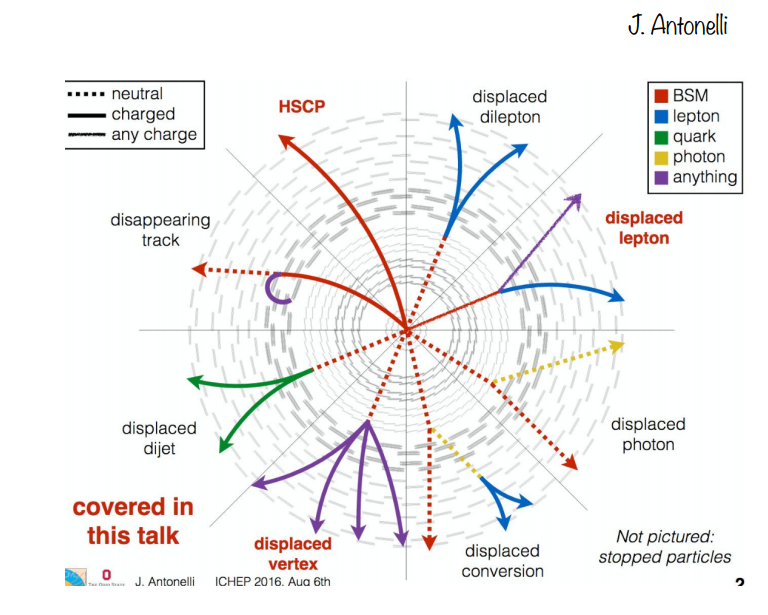

* **support for pyhf**: we will soon be able to make use of the likelihoods provided by pyhf (see separate talk)


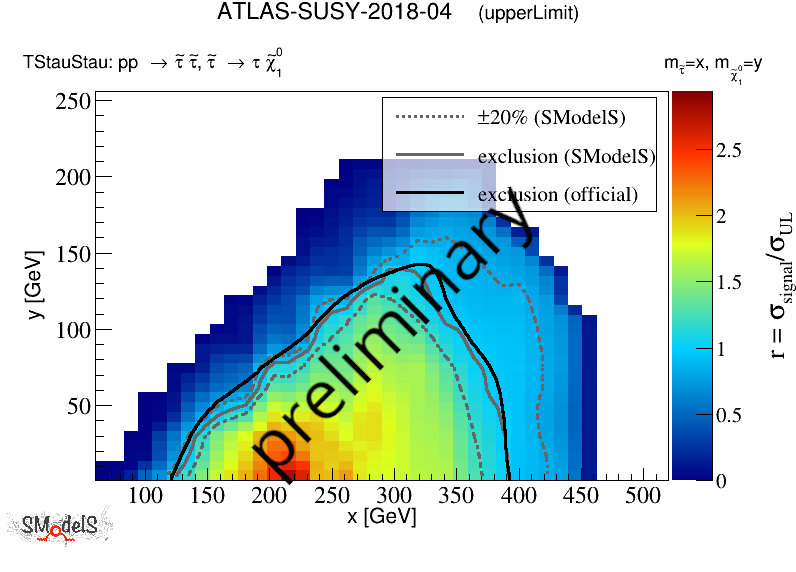

* **combinations of likelihoods**: we aim at publications that describe which 
  analyses in the SModelS database can be considered to be uncorrelated and which cannot. 
  Uncorrelated analyses can then be combined via their likelihoods.

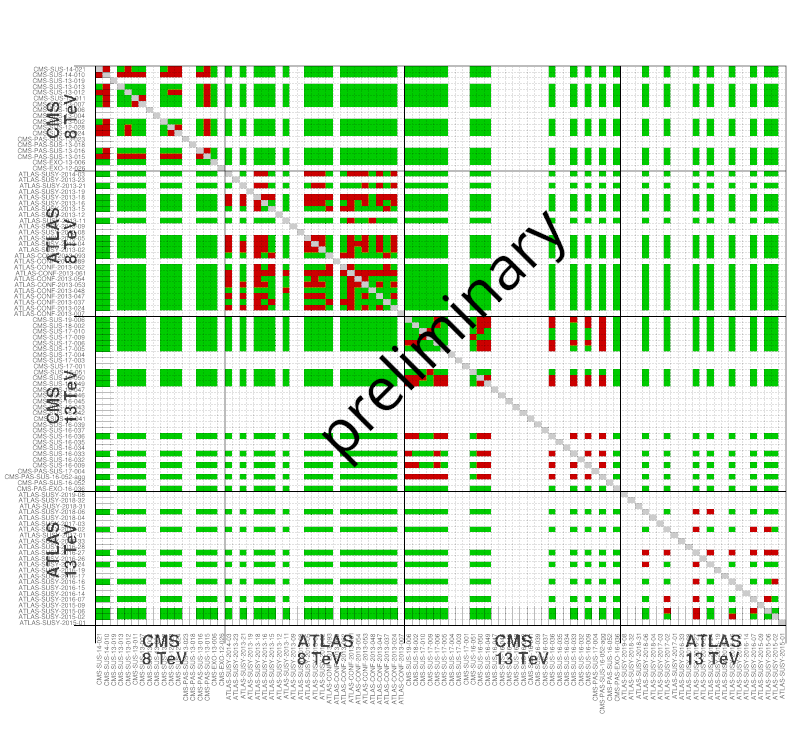

## Part 8: Links and References

**Here is a collection of links around SModelS:**

SModelS proper: https://smodels.github.io

Our repository: https://github.com/SModelS

More python and jupyter examples: https://smodels.readthedocs.io/en/stable/Examples.html

Documentation: https://readthedocs.org/projects/smodels/